In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle datasets download jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip "/content/utkface-new.zip" -d "/content/unzipped_folder"


Archive:  /content/utkface-new.zip
replace /content/unzipped_folder/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/unzipped_folder/UTKFace/100_0_0_20170112215240346.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
folder_path='/content/unzipped_folder/utkface_aligned_cropped/UTKFace'

In [ ]:
!pip install tensorflow --upgrade


In [ ]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
age=[]
gender=[]
img_path=[]
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [ ]:
len(age)

23708

In [ ]:
df=pd.DataFrame({'age':age,'gender':gender,'img':img_path})

In [ ]:
df.head()

,age,gender,img
0,25,1,25_1_1_20170112205216610.jpg.chip.jpg
1,50,1,50_1_0_20170110154254311.jpg.chip.jpg
2,75,1,75_1_0_20170120225821626.jpg.chip.jpg
3,35,0,35_0_0_20170117120948071.jpg.chip.jpg
4,1,0,1_0_2_20161219203016316.jpg.chip.jpg


In [ ]:
train_df=df.sample(frac=1,random_state=0).iloc[:20000]
test_df=df.sample(frac=1,random_state=0).iloc[2000:]


In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255,rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)

test_datagen=ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                    class_mode='multi_output')

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                  class_mode='multi_output')

Found 20000 validated image filenames.
Found 21708 validated image filenames.


In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.models import Model

In [ ]:
resnet = ResNet50(include_top=False, input_shape=(200,200,3))

In [ ]:
resnet = ResNet50(include_top=False, input_shape=(200,200,3))

resnet.trainable=False

output = resnet.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512,activation='relu')(flatten)

dense3 = Dense(512,activation='relu')(dense1)
dense4 = Dense(512,activation='relu')(dense2)

output1 = Dense(1,activation='linear',name='age')(dense3)
output2 = Dense(1,activation='sigmoid',name='gender')(dense4)

In [ ]:
model = Model(inputs=resnet.input,outputs=[output1,output2])

In [ ]:
 model.summary()

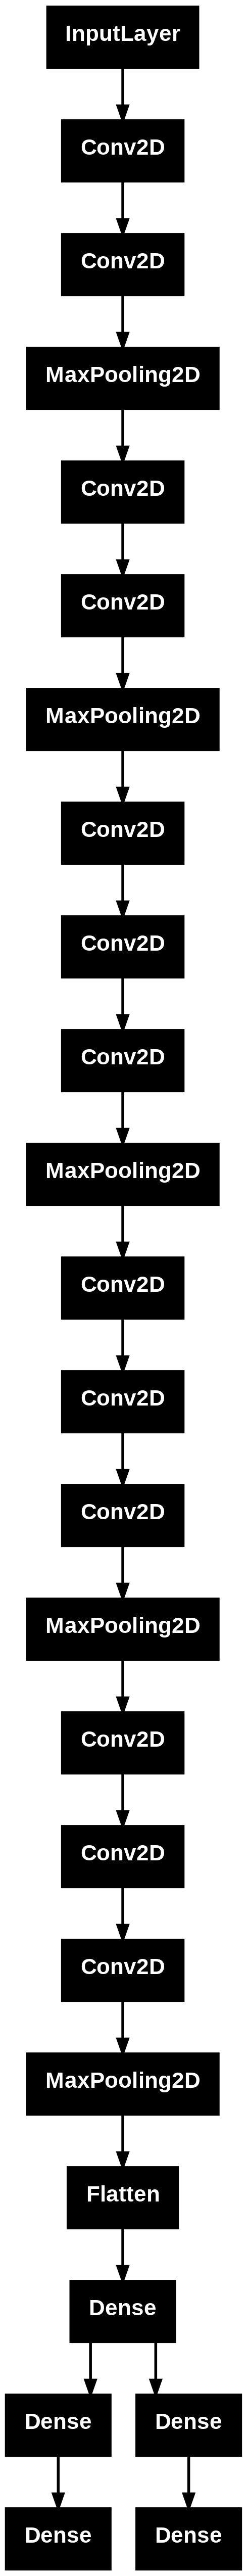

In [95]:
 from keras.utils import plot_model
 plot_model(model)

In [96]:
model.compile(optimizer='adam', loss={'age': 'mae', 'gender': 'binary_crossentropy'}, metrics={'age': 'mae', 'gender': 'accuracy'},loss_weights={'age':1,'gender':99})

In [97]:
model.fit(train_generator, batch_size=32, epochs=10, validation_data=test_generator)